In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)

In [2]:
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, MinMaxScaler
from sklearn.feature_selection import VarianceThreshold, SelectKBest, f_regression
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestRegressor

In [3]:
def convert_categorical_to_numerical(df):
    new_df = df.copy()
    categorical_features = new_df.select_dtypes(include=['object', 'bool']).columns
    print(f'Categorical Features are: {categorical_features}')
    
    # differentiating binary columns and nominal columns
    binary_columns = []
    nominal_columns = []
    
    for column in categorical_features:
        unique_value = new_df[column].nunique()
        if unique_value == 2:
            binary_columns.append(column)
        elif unique_value > 2:
            nominal_columns.append(column)

    print(f'Binary columns are: {binary_columns}')
    print(f'Nominal columns are: {nominal_columns}')
    
    def convert_binary_to_numerical():
        label_encoder = LabelEncoder()
        for column in binary_columns:
            new_df[column] = label_encoder.fit_transform(new_df[column])
    
    def convert_nominal_to_numerical():
        one_hot_encoder = OneHotEncoder(sparse=False)
        encoded_data_mjob = pd.DataFrame(one_hot_encoder.fit_transform(new_df[nominal_columns]),
                                         columns=one_hot_encoder.get_feature_names_out())
        numerical_df = pd.concat([new_df, encoded_data_mjob], axis=1).drop(nominal_columns, axis=1)
        return numerical_df
        
    convert_binary_to_numerical()
    new_df = convert_nominal_to_numerical()
    return new_df

In [4]:
def basic_data_cleaning(df, threshold=0.1):
    # drops the single value columns
    def remove_single_value_column():
        counts = df.nunique()
        to_del = [i for i,v in enumerate(counts) if v == 1]
        if len(to_del) > 0:
            df.drop(to_del, axis=1, inplace=True)
        print(f'Shape after removing single value column: {df.shape}')
    
    # drop the column which has low variance
    def remove_column_with_low_variance(data, threshold):
        selector = VarianceThreshold(threshold=threshold)
        selector.fit_transform(data)
        df = data[data.columns[selector.get_support(indices=True)]]
        print(f'Shape after removing columns with low variance: {df.shape}')
        return df

    # drop duplicate value rows
    def remove_duplicate_value_rows():
        dups = df.duplicated()
        if dups.any():
            print(df[dups])
            df.drop_duplicates(inplace=True)
        print(f'Shape after removing duplicate value: {df.shape}')

    print(f'Shape before doing basic data cleaning: {df.shape}')
    remove_single_value_column()
    # df = remove_column_with_low_variance(df, threshold)
    remove_duplicate_value_rows()
    return df

In [5]:
def fill_missing_Value(df):
    # Fills the missing value in the dataset
    data = df.values
    X, y = data[:, :-1], data[:, -1]
    missing_value_columns = df.columns[df.isna().any()]
    print(f'Missing value columns: {missing_value_columns}')
    imputer = SimpleImputer(missing_values=np.nan, strategy='most_frequent')
    for column in missing_value_columns:
        imputer.fit(df[column].values.reshape(-1, 1))
        df[column] = imputer.fit_transform(df[column].values.reshape(-1, 1))
    print(f'Missing value columns after transform using SimpleImputer: {df.columns[df.isna().any()]}')
    return df

In [6]:
def add_total_score_and_average_score_column(df):
    df['total_score'] = df['G1'] + df['G2'] + df['G3']
    df['average_score'] = (df['G1'] + df['G2'] + df['G3'])/3
    return df

In [7]:
# for detecting outliers will used IQR technique
def detect_outliers(df):
    for column in df.columns:
        q25 = np.percentile(df[column], 25)
        q75 = np.percentile(df[column], 75)
        iqr = q75 - q25
        print('Percentiles for column %s: 25th=%.3f, 75th=%.3f, IQR=%.3f' % (column, q25, q75, iqr))

        cut_off = iqr * 1.5
        lower_bound = q25 - cut_off
        upper_bound = q75 + cut_off
        outliers = [x for x in df[column] if x < lower_bound or x > upper_bound]

        if (len(outliers) > 0):
            print(f'Outlier for {column} are {outliers}')
            print(f'Removing outliers....')

            def remove_outlier():
                for i in df[column]:
                    if i > upper_bound or i < lower_bound:
                        df[column].replace(i, np.mean(df[column]), inplace = True)
            
            remove_outlier()
            print(f'Removed outlier for {column} column')
        else:
            print(f'No outlier for {column} column')
        print('===================================================================================')
    return df

In [8]:
def extract_features(df, criteria, k):
    X = df.drop(['G3'], axis=1).values
    y = df['G3'].values
    feature_selection = SelectKBest(score_func=criteria, k=k)
    feature_selection.fit_transform(X, y)
    cols_idxs = feature_selection.get_support(indices=True)
    # selected_columns = [column for column in df.columns[cols_idxs]]
    return cols_idxs

In [9]:
def normlaize_data(df):
    scaler = MinMaxScaler()
    df_scaled = scaler.fit_transform(df)
    return df_scaled

# Fetching Student Maths performance dataset #

In [10]:
maths_df = pd.read_csv('../notebook/datasets/student-mat.csv', sep=';')
print(f'Shape of maths student performance dataset: {maths_df.shape}')

Shape of maths student performance dataset: (395, 33)


In [11]:
# check statistics of dataset
maths_df.describe()

,age,Medu,Fedu,traveltime,studytime,failures,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3
count,395.000000,395.000000,395.000000,395.000000,395.000000,395.000000,395.000000,395.000000,395.000000,395.000000,395.000000,395.000000,395.000000,395.000000,395.000000,395.000000
mean,16.696203,2.749367,2.521519,1.448101,2.035443,0.334177,3.944304,3.235443,3.108861,1.481013,2.291139,3.554430,5.708861,10.908861,10.713924,10.415190
std,1.276043,1.094735,1.088201,0.697505,0.839240,0.743651,0.896659,0.998862,1.113278,0.890741,1.287897,1.390303,8.003096,3.319195,3.761505,4.581443
min,15.000000,0.000000,0.000000,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,3.000000,0.000000,0.000000
25%,16.000000,2.000000,2.000000,1.000000,1.000000,0.000000,4.000000,3.000000,2.000000,1.000000,1.000000,3.000000,0.000000,8.000000,9.000000,8.000000
50%,17.000000,3.000000,2.000000,1.000000,2.000000,0.000000,4.000000,3.000000,3.000000,1.000000,2.000000,4.000000,4.000000,11.000000,11.000000,11.000000
75%,18.000000,4.000000,3.000000,2.000000,2.000000,0.000000,5.000000,4.000000,4.000000,2.000000,3.000000,5.000000,8.000000,13.000000,13.000000,14.000000
max,22.000000,4.000000,4.000000,4.000000,4.000000,3.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,75.000000,19.000000,19.000000,20.000000


# Adding columns for "total score" and "average" in dataframe

In [12]:
maths_df['total_score'] = maths_df['G1'] + maths_df['G2'] + maths_df['G3']
maths_df['average'] = maths_df['total_score'] / 3

maths_df.head()

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,reason,guardian,traveltime,studytime,failures,schoolsup,famsup,paid,activities,nursery,higher,internet,romantic,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3,total_score,average
0,GP,F,18,U,GT3,A,4,4,at_home,teacher,course,mother,2,2,0,yes,no,no,no,yes,yes,no,no,4,3,4,1,1,3,6,5,6,6,17,5.666667
1,GP,F,17,U,GT3,T,1,1,at_home,other,course,father,1,2,0,no,yes,no,no,no,yes,yes,no,5,3,3,1,1,3,4,5,5,6,16,5.333333
2,GP,F,15,U,LE3,T,1,1,at_home,other,other,mother,1,2,3,yes,no,yes,no,yes,yes,yes,no,4,3,2,2,3,3,10,7,8,10,25,8.333333
3,GP,F,15,U,GT3,T,4,2,health,services,home,mother,1,3,0,no,yes,yes,yes,yes,yes,yes,yes,3,2,2,1,1,5,2,15,14,15,44,14.666667
4,GP,F,16,U,GT3,T,3,3,other,other,home,father,1,2,0,no,yes,yes,no,yes,yes,no,no,4,3,2,1,2,5,4,6,10,10,26,8.666667


In [13]:
G1_full = maths_df[maths_df['G1'] == 20]['average'].count()
G2_full = maths_df[maths_df['G2'] == 20]['average'].count()
G3_full = maths_df[maths_df['G3'] == 20]['average'].count()

print(f'Number of students with full marks in G1: {G1_full}')
print(f'Number of students with full marks in G2: {G2_full}')
print(f'Number of students with full marks in G3: {G3_full}')

Number of students with full marks in G1: 0
Number of students with full marks in G2: 0
Number of students with full marks in G3: 1


In [14]:
G1_less_than_5 = maths_df[maths_df['G1'] <= 5]['average'].count()
G2_less_than_5 = maths_df[maths_df['G2'] <= 5]['average'].count()
G3_less_than_5 = maths_df[maths_df['G3'] <= 5]['average'].count()

print(f'Number of students with less than or equal to 5 marks in G1: {G1_less_than_5}')
print(f'Number of students with less than or equal to 5 marks in G2: {G2_less_than_5}')
print(f'Number of students with less than or equal to 5 marks in G3: {G3_less_than_5}')

Number of students with less than or equal to 5 marks in G1: 9
Number of students with less than or equal to 5 marks in G2: 29
Number of students with less than or equal to 5 marks in G3: 46


#### Insights: ####
* From the above result we can say thay in G3 exam, student had performed worst
* Best performance is in the G1 exam

# Converting Categorical columns to numerical columns #

In [15]:
new_maths_df = convert_categorical_to_numerical(maths_df)
new_maths_df.head()

Categorical Features are: Index(['school', 'sex', 'address', 'famsize', 'Pstatus', 'Mjob', 'Fjob',
       'reason', 'guardian', 'schoolsup', 'famsup', 'paid', 'activities',
       'nursery', 'higher', 'internet', 'romantic'],
      dtype='object')
Binary columns are: ['school', 'sex', 'address', 'famsize', 'Pstatus', 'schoolsup', 'famsup', 'paid', 'activities', 'nursery', 'higher', 'internet', 'romantic']
Nominal columns are: ['Mjob', 'Fjob', 'reason', 'guardian']


,school,sex,age,address,famsize,Pstatus,Medu,Fedu,traveltime,studytime,failures,schoolsup,famsup,paid,activities,nursery,higher,internet,romantic,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3,total_score,average,Mjob_at_home,Mjob_health,Mjob_other,Mjob_services,Mjob_teacher,Fjob_at_home,Fjob_health,Fjob_other,Fjob_services,Fjob_teacher,reason_course,reason_home,reason_other,reason_reputation,guardian_father,guardian_mother,guardian_other
0,0,0,18,1,0,0,4,4,2,2,0,1,0,0,0,1,1,0,0,4,3,4,1,1,3,6,5,6,6,17,5.666667,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
1,0,0,17,1,0,1,1,1,1,2,0,0,1,0,0,0,1,1,0,5,3,3,1,1,3,4,5,5,6,16,5.333333,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
2,0,0,15,1,1,1,1,1,1,2,3,1,0,1,0,1,1,1,0,4,3,2,2,3,3,10,7,8,10,25,8.333333,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
3,0,0,15,1,0,1,4,2,1,3,0,0,1,1,1,1,1,1,1,3,2,2,1,1,5,2,15,14,15,44,14.666667,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
4,0,0,16,1,0,1,3,3,1,2,0,0,1,1,0,1,1,0,0,4,3,2,1,2,5,4,6,10,10,26,8.666667,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0


# Exploring Data (Visualization) #

### 1. Generating the correlation between each features ###

Text(0.5, 1.0, 'Correlation Heatmap')

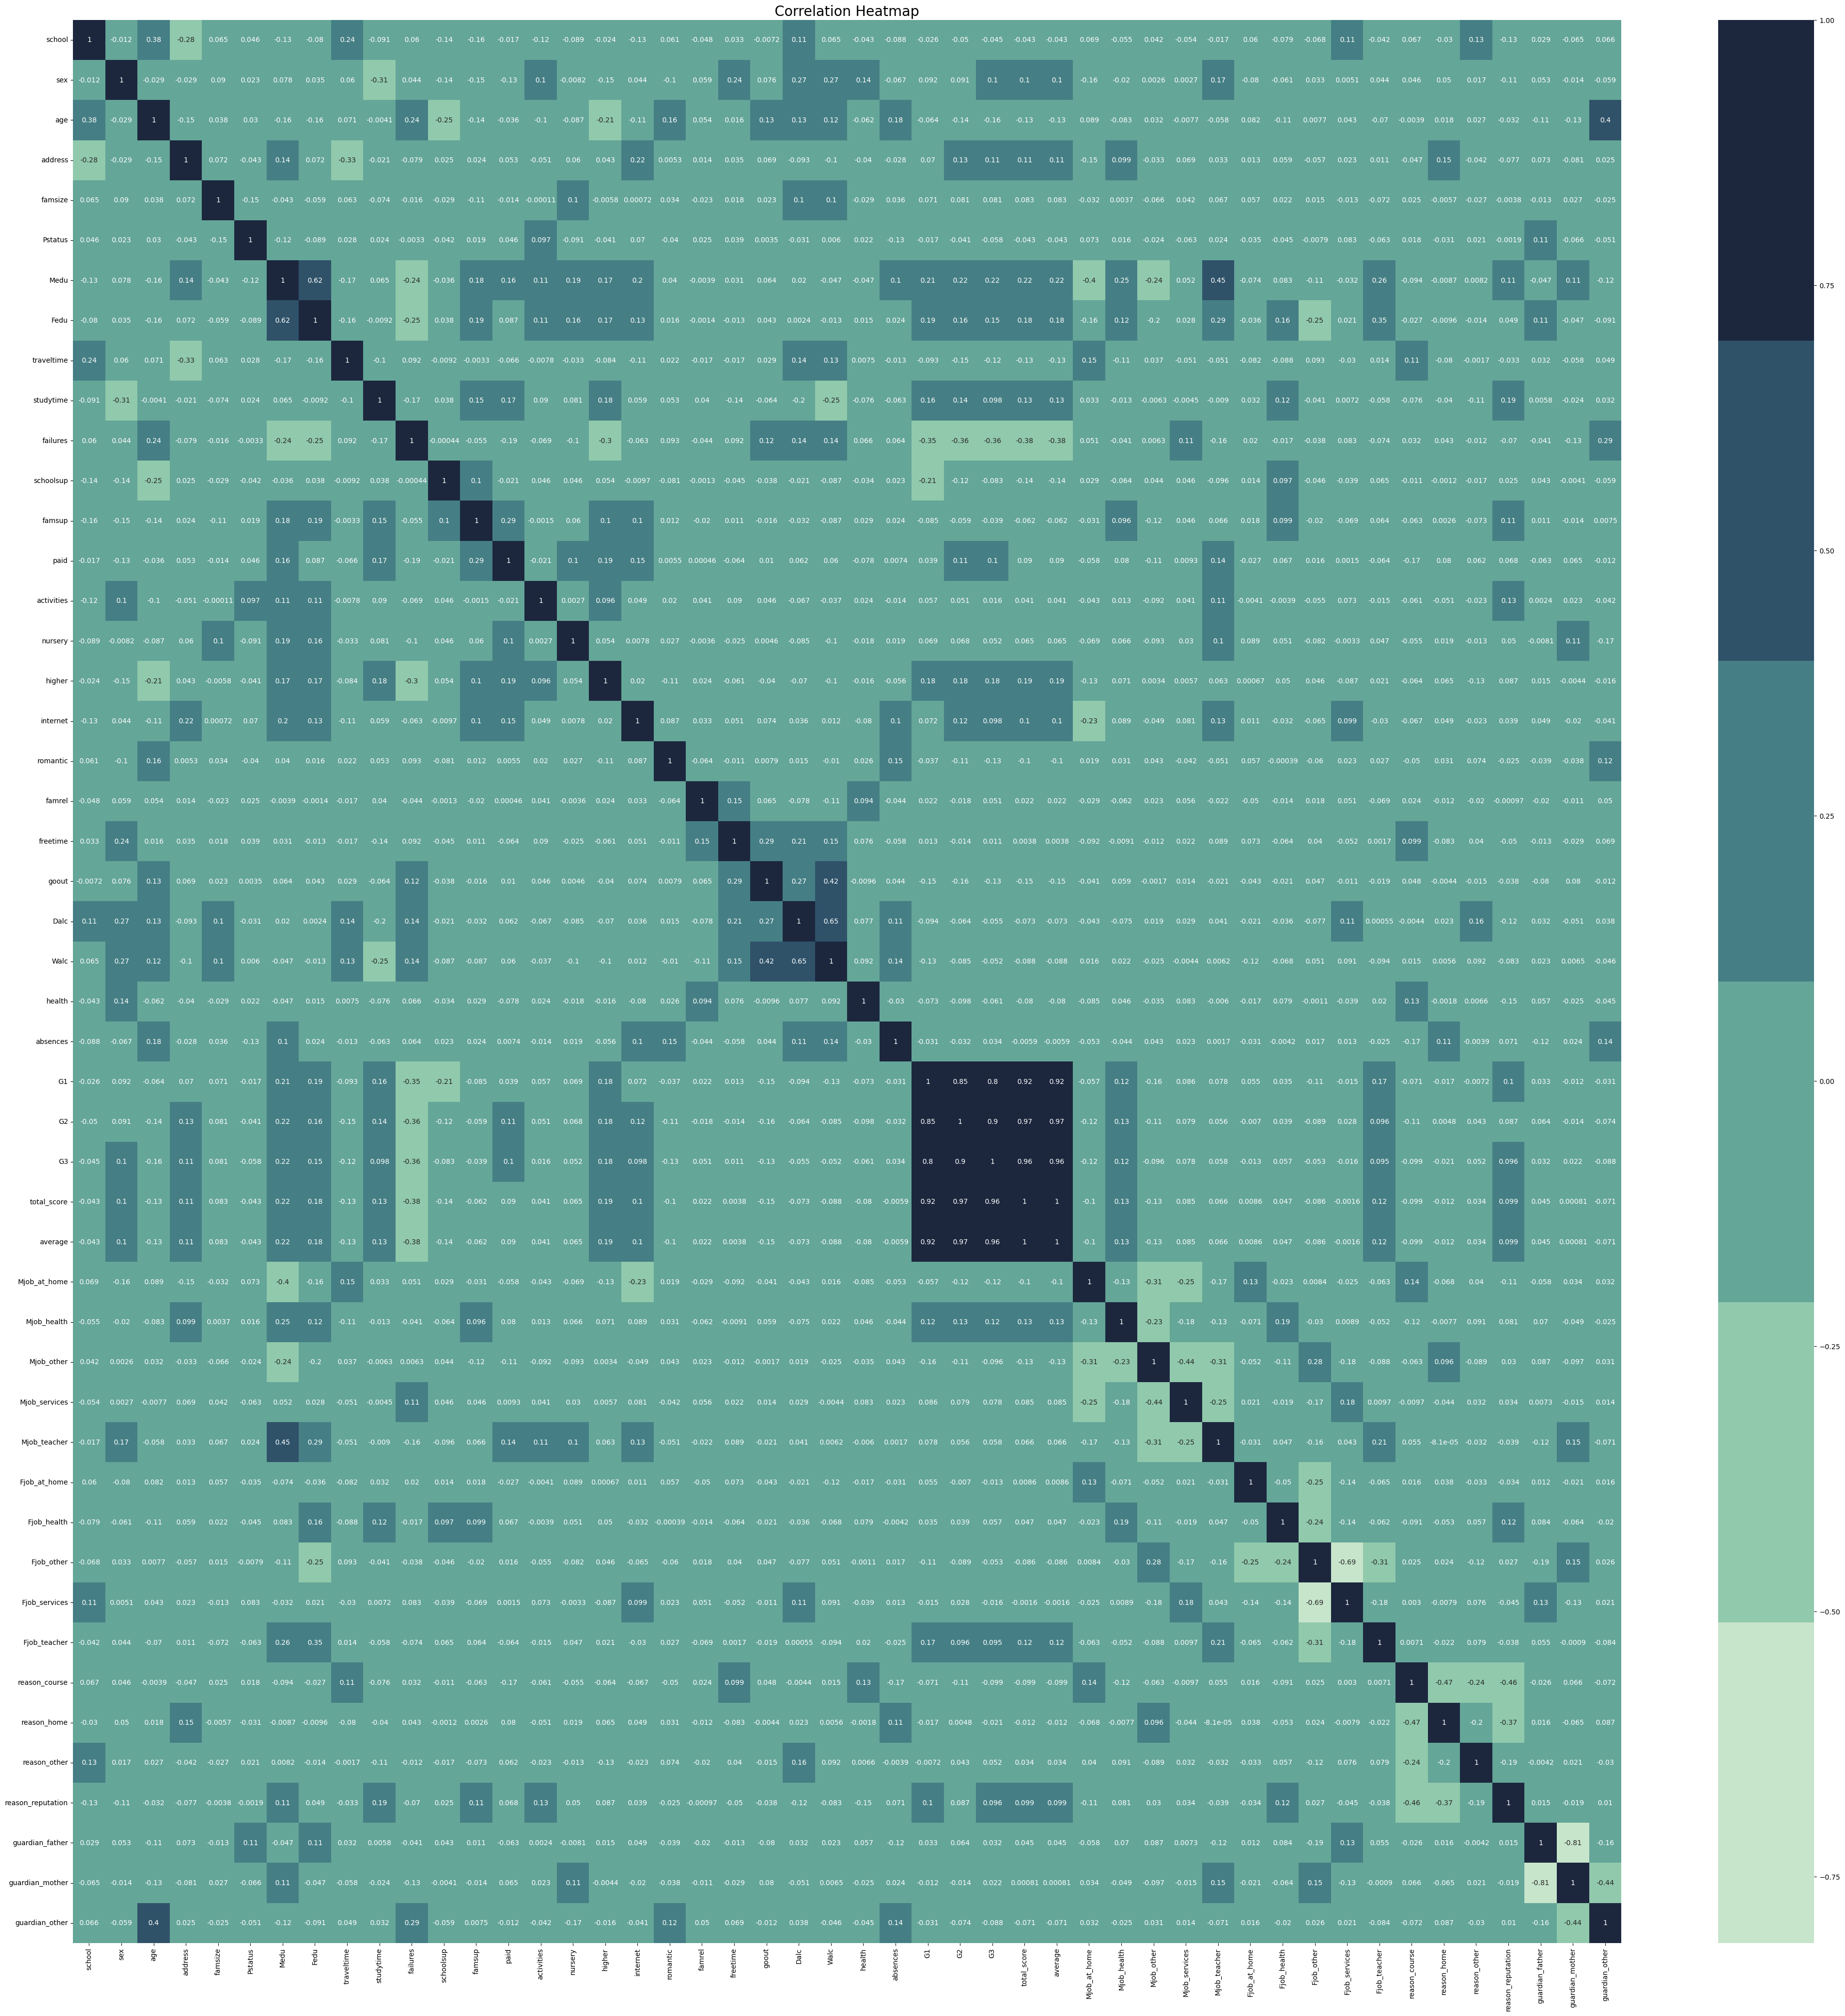

In [16]:
corr = new_maths_df.corr()
plt.figure(figsize=(50,50))
sns.heatmap(corr, annot=True, cmap=sns.cubehelix_palette(rot=-.4))
plt.title('Correlation Heatmap', fontsize=20)

In [17]:
# removing high co-related columns
new_maths_df.drop(['Dalc', 'goout', 'Medu'], axis=1, inplace=True)
new_maths_df.shape

(395, 45)

### 2. Visualizing average score and total score distribution to make some conclusion ###
* Histogram
* Kernel Distribution Function (KDE)

2.1 Average score vs Sex

<AxesSubplot: xlabel='average', ylabel='Count'>

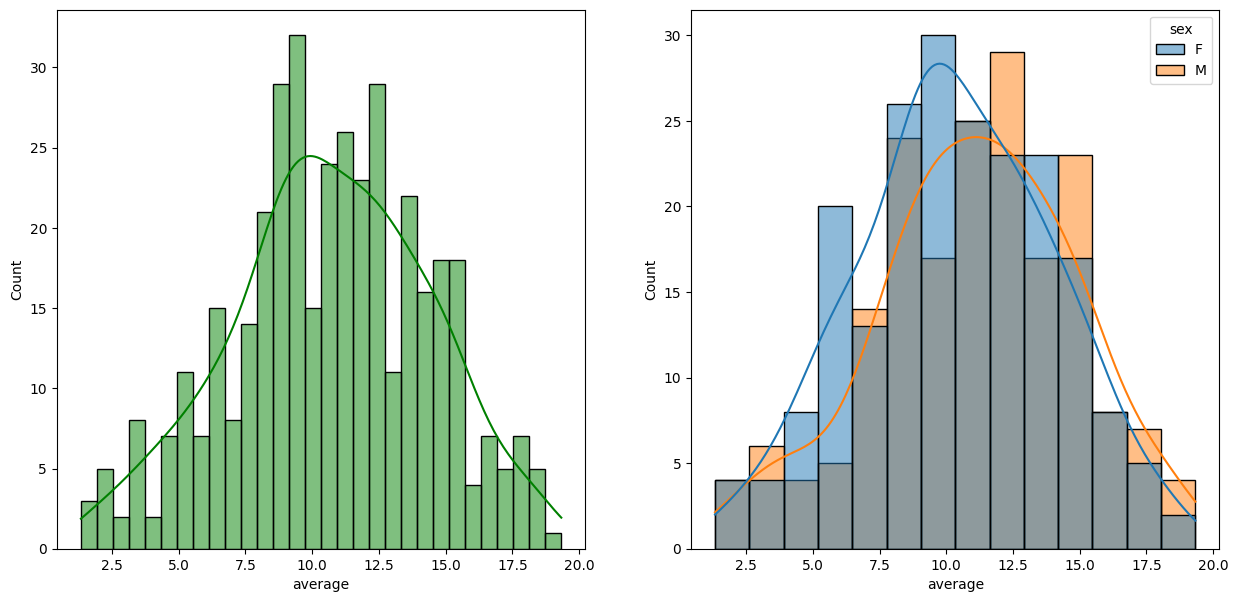

In [18]:
fig, axs = plt.subplots(1, 2, figsize=(15, 7))
plt.subplot(121)
sns.histplot(data=maths_df, x = 'average', bins=30, kde=True, color='g')
plt.subplot(122)
sns.histplot(data=maths_df, x = 'average', kde=True, hue='sex')

2.2 Total Score vs Sex

<AxesSubplot: xlabel='total_score', ylabel='Count'>

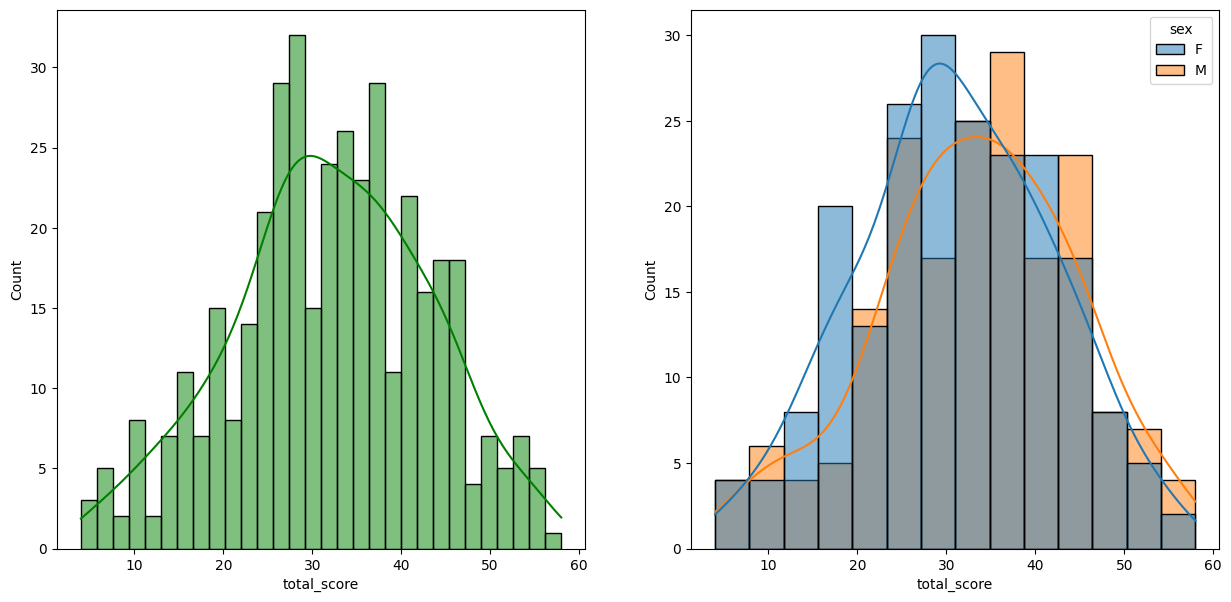

In [19]:
fig, axs = plt.subplots(1, 2, figsize=(15, 7))
plt.subplot(121)
sns.histplot(data=maths_df, x = 'total_score', bins=30, kde=True, color='g')
plt.subplot(122)
sns.histplot(data=maths_df, x = 'total_score', kde=True, hue='sex')

Insights:
* Male students tend to perform well then female student

2.3 Father's education vs total_score 

<AxesSubplot: xlabel='total_score', ylabel='Count'>

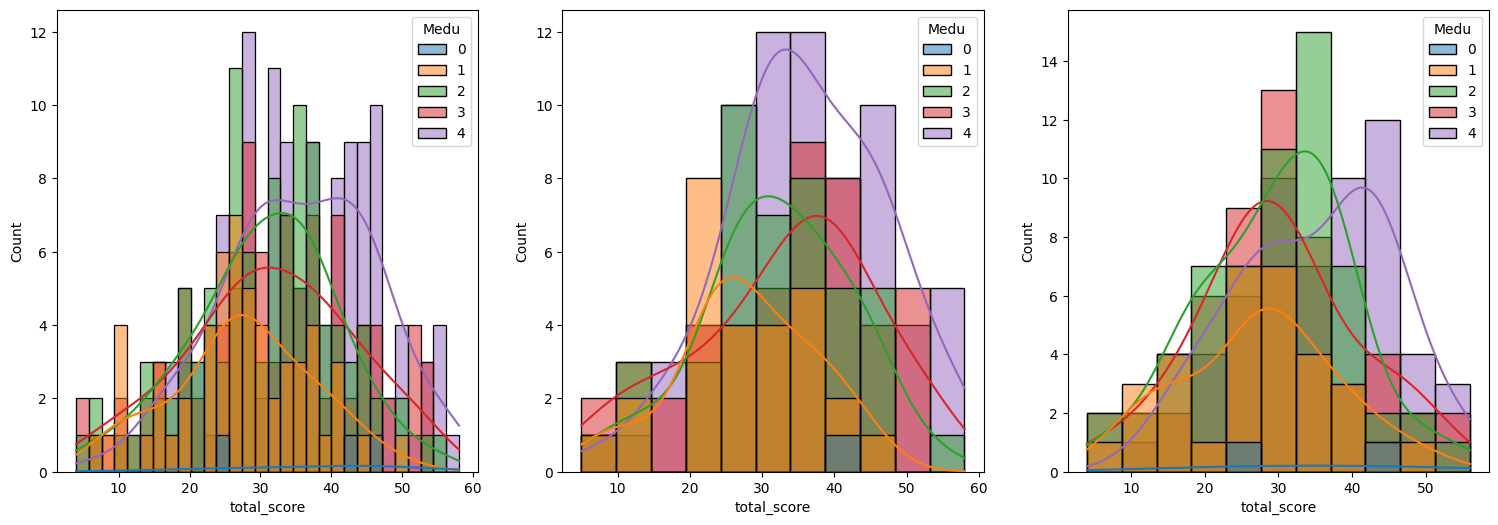

In [37]:
fig, axs = plt.subplots(1, 3, figsize=(25, 6))
plt.subplot(141)
sns.histplot(data = maths_df, x = 'total_score', bins = 30, kde = True, hue = 'Medu', 
             palette={0: "C0", 1: "C1", 2: "C2", 3: "C3", 4: "C4"})
plt.subplot(142)
sns.histplot(data = maths_df[maths_df.sex == 'M'], x = 'total_score', kde = True, hue = 'Medu', 
             palette={0: "C0", 1: "C1", 2: "C2", 3: "C3", 4: "C4"})
plt.subplot(143)
sns.histplot(data = maths_df[maths_df.sex == 'F'], x = 'total_score', kde = True, hue = 'Medu', 
             palette={0: "C0", 1: "C1", 2: "C2", 3: "C3", 4: "C4"})

Insights:
* In general, fathers having higher education, then student (M/F) will perform will and get a good mark

2.4 Mother's education vs total_score 

<AxesSubplot: xlabel='total_score', ylabel='Count'>

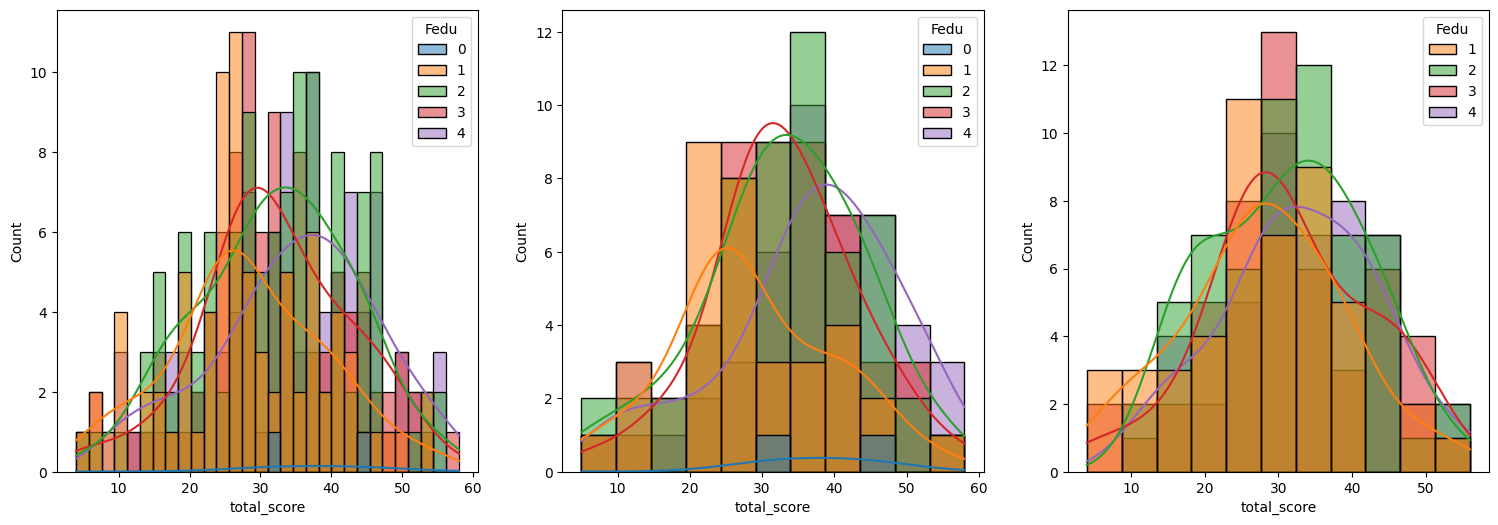

In [38]:
fig, axs = plt.subplots(1, 3, figsize=(25, 6))
plt.subplot(141)
sns.histplot(data = maths_df, x = 'total_score', bins = 30, kde = True, hue = 'Fedu', 
             palette={0: "C0", 1: "C1", 2: "C2", 3: "C3", 4: "C4"})
plt.subplot(142)
sns.histplot(data = maths_df[maths_df.sex == 'M'], x = 'total_score', kde = True, hue = 'Fedu', 
             palette={0: "C0", 1: "C1", 2: "C2", 3: "C3", 4: "C4"})
plt.subplot(143)
sns.histplot(data = maths_df[maths_df.sex == 'F'], x = 'total_score', kde = True, hue = 'Fedu', 
             palette={0: "C0", 1: "C1", 2: "C2", 3: "C3", 4: "C4"})

Insights
* In general mother's education don't help student perform well in exam. 

2.5 Romantic relationship vs Total Score

<AxesSubplot: xlabel='total_score', ylabel='Count'>

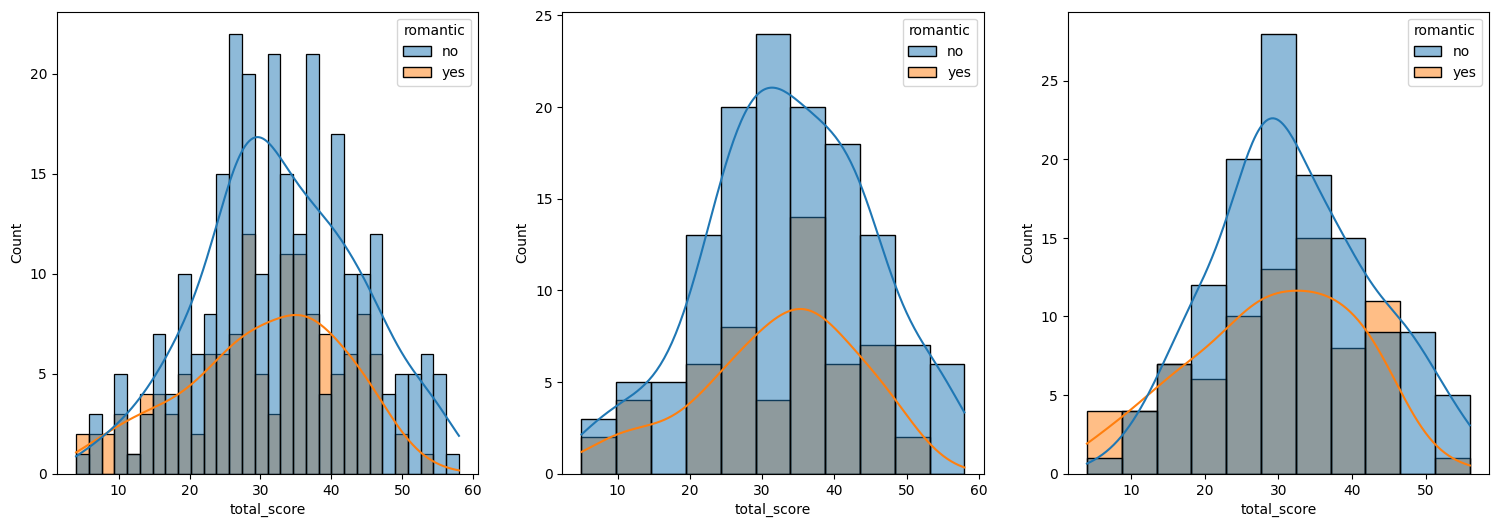

In [39]:
fig, axs = plt.subplots(1, 3, figsize=(25, 6))
plt.subplot(141)
sns.histplot(data = maths_df, x = 'total_score', bins = 30, kde = True, hue = 'romantic', color='g')
plt.subplot(142)
sns.histplot(data = maths_df[maths_df.sex == 'M'], x = 'total_score', kde = True, hue = 'romantic')
plt.subplot(143)
sns.histplot(data = maths_df[maths_df.sex == 'F'], x = 'total_score', kde = True, hue = 'romantic')

Insights:
* The students (M/F) which dont have romantic relationship, tends to perform well in exam

2.6 Weekend alcohol consumption vs total score

<AxesSubplot: xlabel='total_score', ylabel='Count'>

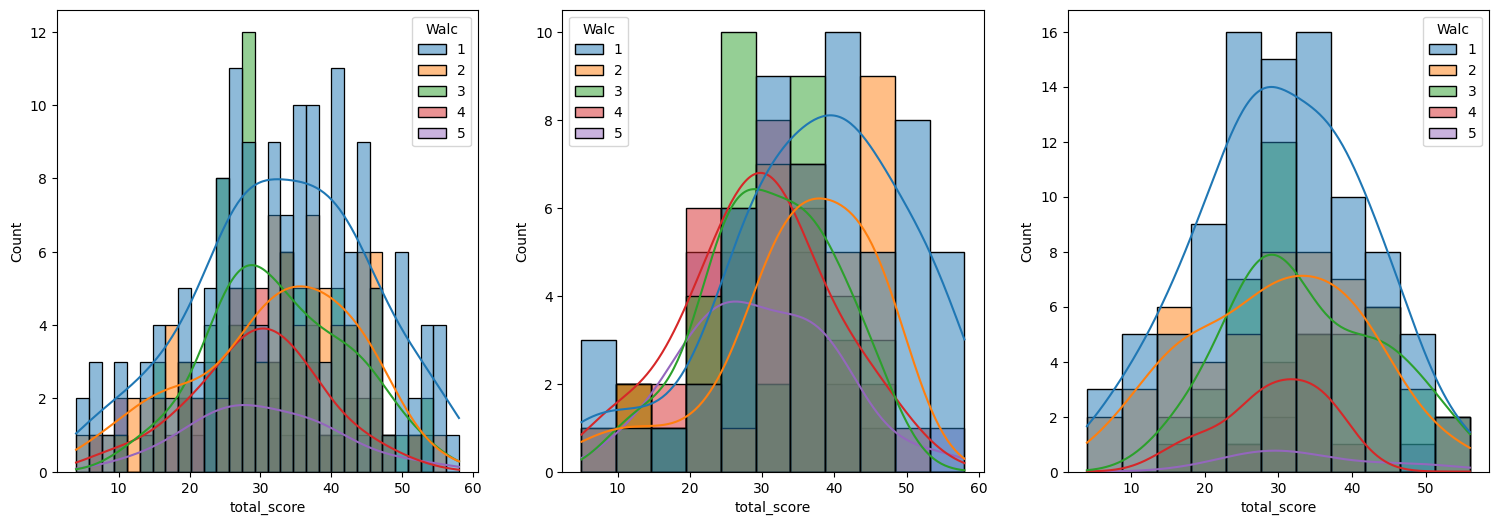

In [42]:
fig, axs = plt.subplots(1, 3, figsize=(25, 6))
plt.subplot(141)
sns.histplot(data = maths_df, x = 'total_score', bins = 30, kde = True, hue = 'Walc', color='g',
             palette={1: "C0", 2: "C1", 3: "C2", 4: "C3", 5: "C4"})
plt.subplot(142)
sns.histplot(data = maths_df[maths_df.sex == 'M'], x = 'total_score', kde = True, hue = 'Walc',
             palette={1: "C0", 2: "C1", 3: "C2", 4: "C3", 5: "C4"})
plt.subplot(143)
sns.histplot(data = maths_df[maths_df.sex == 'F'], x = 'total_score', kde = True, hue = 'Walc',
             palette={1: "C0", 2: "C1", 3: "C2", 4: "C3", 5: "C4"})

Insights:
* The students (M/F) who take less alcohol in the weekend, tends to perform well

2.7 Weekday alcohol consumption vs total score

<AxesSubplot: xlabel='total_score', ylabel='Count'>

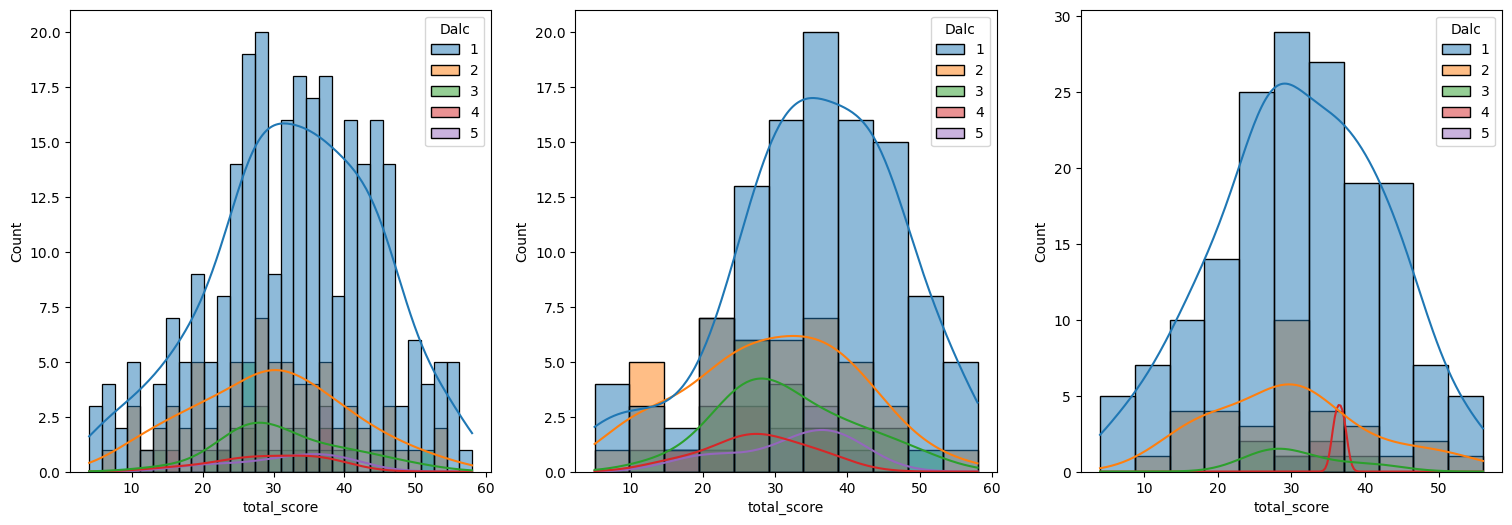

In [45]:
fig, axs = plt.subplots(1, 3, figsize=(25, 6))
plt.subplot(141)
sns.histplot(data = maths_df, x = 'total_score', bins = 30, kde = True, hue = 'Dalc', color='g',
             palette={1: "C0", 2: "C1", 3: "C2", 4: "C3", 5: "C4"})
plt.subplot(142)
sns.histplot(data = maths_df[maths_df.sex == 'M'], x = 'total_score', kde = True, hue = 'Dalc',
             palette={1: "C0", 2: "C1", 3: "C2", 4: "C3", 5: "C4"})
plt.subplot(143)
sns.histplot(data = maths_df[maths_df.sex == 'F'], x = 'total_score', kde = True, hue = 'Dalc',
             palette={1: "C0", 2: "C1", 3: "C2", 4: "C3", 5: "C4"})

Insights:
* The students (M/F) who take less alcohol in the weekdays, tends to perform well

2.8 Going Out with friends vs total score

<AxesSubplot: xlabel='total_score', ylabel='Count'>

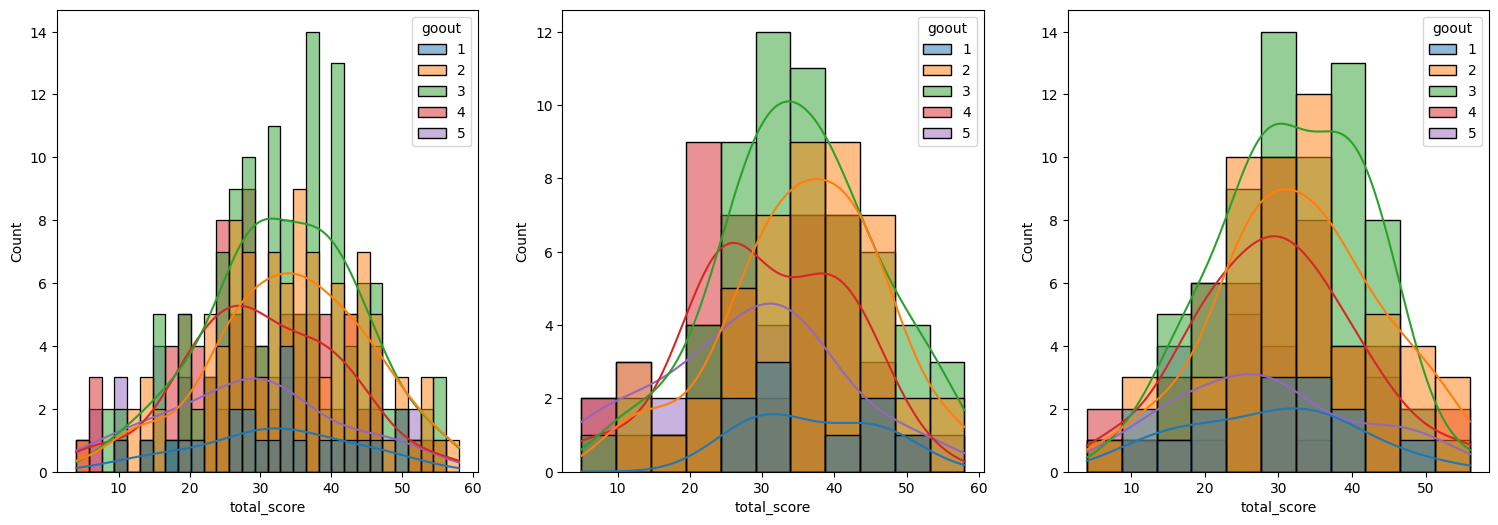

In [48]:
fig, axs = plt.subplots(1, 3, figsize=(25, 6))
plt.subplot(141)
sns.histplot(data = maths_df, x = 'total_score', bins = 30, kde = True, hue = 'goout', color='g',
             palette={1: "C0", 2: "C1", 3: "C2", 4: "C3", 5: "C4"})
plt.subplot(142)
sns.histplot(data = maths_df[maths_df.sex == 'M'], x = 'total_score', kde = True, hue = 'goout',
             palette={1: "C0", 2: "C1", 3: "C2", 4: "C3", 5: "C4"})
plt.subplot(143)
sns.histplot(data = maths_df[maths_df.sex == 'F'], x = 'total_score', kde = True, hue = 'goout',
             palette={1: "C0", 2: "C1", 3: "C2", 4: "C3", 5: "C4"})

Insights:
* A student(M/F) total score is not that much related to going out with friends 

2.9 total score vs higher education

<AxesSubplot: xlabel='total_score', ylabel='Count'>

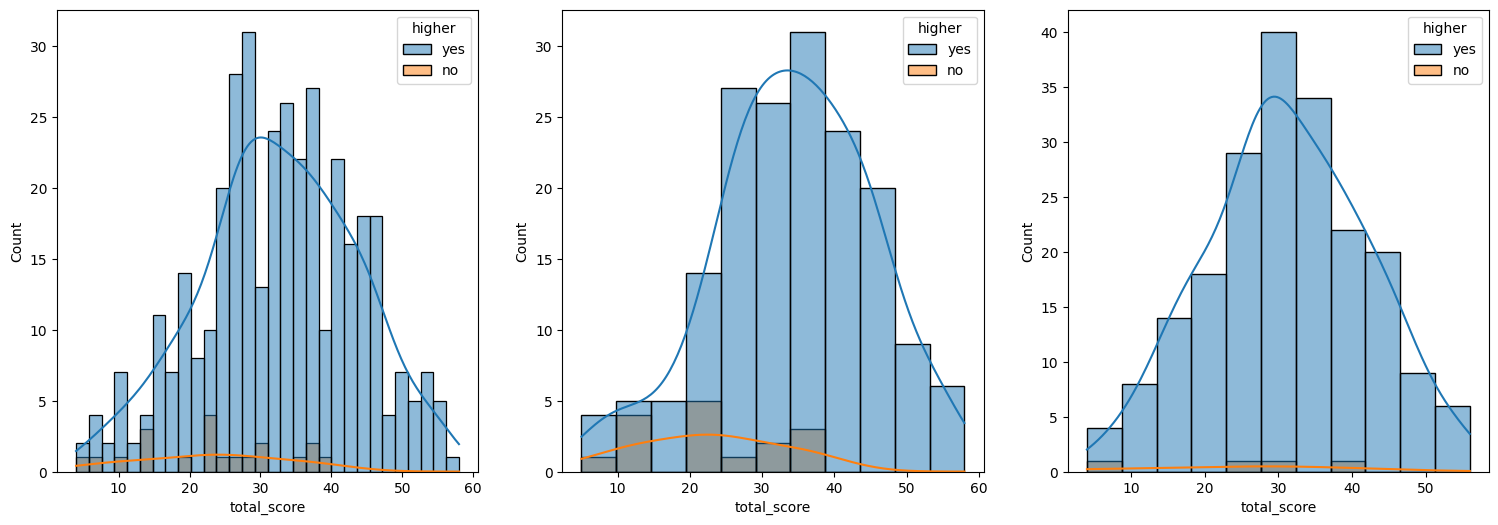

In [58]:
fig, axs = plt.subplots(1, 3, figsize=(25, 6))
plt.subplot(141)
sns.histplot(data = maths_df, x = 'total_score', bins = 30, kde = True, hue = 'higher', color='g')
plt.subplot(142)
sns.histplot(data = maths_df[maths_df.sex == 'M'], x = 'total_score', kde = True, hue = 'higher')
plt.subplot(143)
sns.histplot(data = maths_df[maths_df.sex == 'F'], x = 'total_score', kde = True, hue = 'higher')

Insights:
* Students (M/F) who is willing to have a higer education, tends to perform good in exam

In [59]:
new_maths_df.columns

Index(['school', 'sex', 'age', 'address', 'famsize', 'Pstatus', 'Fedu',
       'traveltime', 'studytime', 'failures', 'schoolsup', 'famsup', 'paid',
       'activities', 'nursery', 'higher', 'internet', 'romantic', 'famrel',
       'freetime', 'Walc', 'health', 'absences', 'G1', 'G2', 'G3',
       'total_score', 'average', 'Mjob_at_home', 'Mjob_health', 'Mjob_other',
       'Mjob_services', 'Mjob_teacher', 'Fjob_at_home', 'Fjob_health',
       'Fjob_other', 'Fjob_services', 'Fjob_teacher', 'reason_course',
       'reason_home', 'reason_other', 'reason_reputation', 'guardian_father',
       'guardian_mother', 'guardian_other'],
      dtype='object')

# Basic Data cleaning #

In [18]:
new_maths_df = basic_data_cleaning(new_maths_df)

Shape before doing basic data cleaning: (395, 45)
Shape after removing single value column: (395, 45)
Shape after removing duplicate value: (395, 45)


# Fill missing value #

In [61]:
new_maths_df = fill_missing_Value(new_maths_df)

Missing value columns: Index([], dtype='object')
Missing value columns after transform using SimpleImputer: Index([], dtype='object')


In [62]:
new_maths_df.head(10)

,school,sex,age,address,famsize,Pstatus,Fedu,traveltime,studytime,failures,schoolsup,famsup,paid,activities,nursery,higher,internet,romantic,famrel,freetime,Walc,health,absences,G1,G2,G3,total_score,average,Mjob_at_home,Mjob_health,Mjob_other,Mjob_services,Mjob_teacher,Fjob_at_home,Fjob_health,Fjob_other,Fjob_services,Fjob_teacher,reason_course,reason_home,reason_other,reason_reputation,guardian_father,guardian_mother,guardian_other
0,0,0,18,1,0,0,4,2,2,0,1,0,0,0,1,1,0,0,4,3,1,3,6,5,6,6,17,5.666667,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
1,0,0,17,1,0,1,1,1,2,0,0,1,0,0,0,1,1,0,5,3,1,3,4,5,5,6,16,5.333333,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
2,0,0,15,1,1,1,1,1,2,3,1,0,1,0,1,1,1,0,4,3,3,3,10,7,8,10,25,8.333333,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
3,0,0,15,1,0,1,2,1,3,0,0,1,1,1,1,1,1,1,3,2,1,5,2,15,14,15,44,14.666667,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
4,0,0,16,1,0,1,3,1,2,0,0,1,1,0,1,1,0,0,4,3,2,5,4,6,10,10,26,8.666667,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
5,0,1,16,1,1,1,3,1,2,0,0,1,1,1,1,1,1,0,5,4,2,5,10,15,15,15,45,15.000000,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
6,0,1,16,1,1,1,2,1,2,0,0,0,0,0,1,1,1,0,4,4,1,3,0,12,12,11,35,11.666667,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
7,0,0,17,1,0,0,4,2,2,0,1,1,0,0,1,1,0,0,4,1,1,1,6,6,5,6,17,5.666667,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
8,0,1,15,1,1,0,2,1,2,0,0,1,1,0,1,1,1,0,4,2,1,1,0,16,18,19,53,17.666667,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
9,0,1,15,1,0,1,4,1,2,0,0,1,1,1,1,1,1,0,5,5,1,5,0,14,15,15,44,14.666667,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0


# Feature Extraction #

In [80]:
dummy_df = new_maths_df.drop(['total_score', 'average'], axis=1)
extracted_features_df= dummy_df.iloc[:, extract_features(dummy_df, f_regression, 30)]
extracted_features_df.columns

Index(['sex', 'age', 'address', 'famsize', 'Pstatus', 'Fedu', 'traveltime',
       'studytime', 'failures', 'schoolsup', 'paid', 'higher', 'internet',
       'romantic', 'Walc', 'health', 'G1', 'G2', 'G3', 'Mjob_at_home',
       'Mjob_health', 'Mjob_other', 'Mjob_services', 'Fjob_at_home',
       'Fjob_health', 'Fjob_services', 'Fjob_teacher', 'reason_home',
       'reason_other', 'guardian_mother'],
      dtype='object')

Feature: 0, Score: 0.00003
Feature: 1, Score: 0.00009
Feature: 2, Score: 0.00040
Feature: 3, Score: 0.00019
Feature: 4, Score: 0.00014
Feature: 5, Score: 0.00003
Feature: 6, Score: 0.00045
Feature: 7, Score: 0.00011
Feature: 8, Score: 0.00021
Feature: 9, Score: 0.00114
Feature: 10, Score: 0.00008
Feature: 11, Score: 0.00019
Feature: 12, Score: 0.00024
Feature: 13, Score: 0.00011
Feature: 14, Score: 0.00013
Feature: 15, Score: 0.00011
Feature: 16, Score: 0.00005
Feature: 17, Score: 0.00015
Feature: 18, Score: 0.00029
Feature: 19, Score: 0.00021
Feature: 20, Score: 0.00031
Feature: 21, Score: 0.00046
Feature: 22, Score: 0.00150
Feature: 23, Score: 0.02209
Feature: 24, Score: 0.73216
Feature: 25, Score: 0.23767
Feature: 26, Score: 0.00007
Feature: 27, Score: 0.00006
Feature: 28, Score: 0.00013
Feature: 29, Score: 0.00016
Feature: 30, Score: 0.00007
Feature: 31, Score: 0.00003
Feature: 32, Score: 0.00001
Feature: 33, Score: 0.00012
Feature: 34, Score: 0.00017
Feature: 35, Score: 0.00006
Fe

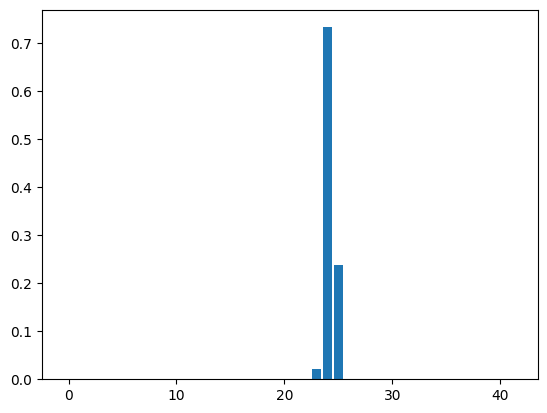

In [79]:
# extracted features -> feature importance
X = extracted_features_df.values
model = RandomForestRegressor()
# fit the model
model.fit(X, maths_df.values[:,-1])
# get importance
importance = model.feature_importances_
# summarize feature importance
for i,v in enumerate(importance):
    print('Feature: %0d, Score: %.5f' % (i,v))
# plot feature importance
plt.bar([x for x in range(len(importance))], importance)
plt.show()

# Normalizing the extracted feature

In [85]:
normalize_maths_df = pd.DataFrame(normlaize_data(extracted_features_df), columns = extracted_features_df.columns)
normalize_maths_df.describe()

,sex,age,address,famsize,Pstatus,Fedu,traveltime,studytime,failures,schoolsup,paid,higher,internet,romantic,Walc,health,G1,G2,G3,Mjob_at_home,Mjob_health,Mjob_other,Mjob_services,Fjob_at_home,Fjob_health,Fjob_services,Fjob_teacher,reason_home,reason_other,guardian_mother
count,395.000000,395.000000,395.000000,395.000000,395.000000,395.00000,395.000000,395.000000,395.000000,395.000000,395.000000,395.000000,395.000000,395.000000,395.000000,395.000000,395.000000,395.000000,395.000000,395.000000,395.000000,395.000000,395.000000,395.000000,395.000000,395.000000,395.000000,395.000000,395.000000,395.000000
mean,0.473418,0.242315,0.777215,0.288608,0.896203,0.63038,0.149367,0.345148,0.111392,0.129114,0.458228,0.949367,0.832911,0.334177,0.322785,0.638608,0.494304,0.563891,0.520759,0.149367,0.086076,0.356962,0.260759,0.050633,0.045570,0.281013,0.073418,0.275949,0.091139,0.691139
std,0.499926,0.182292,0.416643,0.453690,0.305384,0.27205,0.232502,0.279747,0.247884,0.335751,0.498884,0.219525,0.373528,0.472300,0.321974,0.347576,0.207450,0.197974,0.229072,0.356902,0.280832,0.479711,0.439606,0.219525,0.208814,0.450064,0.261152,0.447558,0.288172,0.462610
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.142857,1.000000,0.000000,1.000000,0.50000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.500000,0.312500,0.473684,0.400000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.285714,1.000000,0.000000,1.000000,0.50000,0.000000,0.333333,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.250000,0.750000,0.500000,0.578947,0.550000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
75%,1.000000,0.428571,1.000000,1.000000,1.000000,0.75000,0.333333,0.333333,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.500000,1.000000,0.625000,0.684211,0.700000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


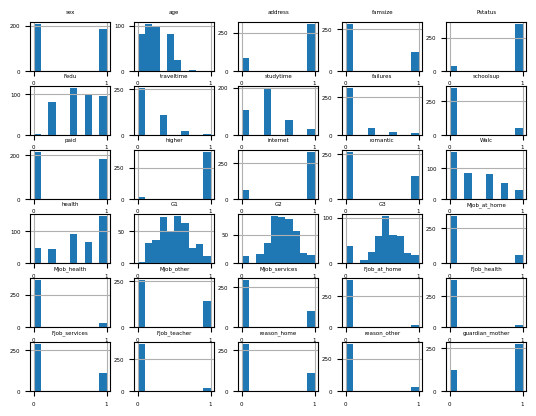

In [86]:
fig = normalize_maths_df.hist(xlabelsize=4, ylabelsize=4)
[x.title.set_size(4) for x in fig.ravel()]
plt.show()